In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

- X 피처들 , y 타겟값('SalePrice')
- 전처리 순서: shape, 결측값, 숫자형인지 확인 / X,y 데이터를 표준화, 정규화, 로그변환 등..(정규분포를 따르는 게 좋으니까) +문자형은 원-핫인코딩(for 선형회귀)

In [2]:
#house_df_org: 원본을 저장하고, 이를 카피한 것으로 데이터 전처리를 수행한다.
house_df_org = pd.read_csv('05/houseprice/train.csv') #원본
house_df = house_df_org.copy()
house_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


##### RMSLE를 사용하는 이유?
- RMSE에서 Log를 적용한 평가지표. 큰 것을 작게 만들기 위함이다.
- 왜냐하면 평가지표 자체가 (실제값-예측값)을 보여준 건데 이 실제값과 예측값이 전부 target에 관한 것임.
- 아무리 예측 성능이 좋더라도(예측을 많이 맞췄더라도), 만일 target의 값이 큰 것의 예측을 실패해 버리면, 평가지표에서는 얘가 예측을 못한다고 본다.(평가지표 값이 크게 나온다.=오류가 크다라고 해석)
- 이 데이터도 특히나 target이 'SalePrice'로, 집값임. 아주 큰값이라서 로그로 작게 낮춰줘야 한다.

In [3]:
house_df.shape

(1460, 81)

In [4]:
#house_df.info() 여기서 피처값이 너무 많아서,, 한번에 dtype별로 묶어서 보겠음.
print(house_df.dtypes.value_counts()) #house_df.dtypes는 피처와 데이터 타입->value_counts()
                                                                                    #-->문자형이 43개 정도 있음.

object     43
int64      35
float64     3
dtype: int64


In [5]:
house_df.dtypes[75:] #target값은 숫자형

MiscVal           int64
MoSold            int64
YrSold            int64
SaleType         object
SaleCondition    object
SalePrice         int64
dtype: object

In [6]:
#결측값 알아보기
print(type(house_df.isnull().sum())) 
isnull_series = house_df.isnull().sum() #시리즈-시리즈에서도 불린 인덱싱 가능!
isnull_series[isnull_series>0] 
                                                       #--> 결측값이 있는 컬럼이 많음..

<class 'pandas.core.series.Series'>


LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [7]:
#결측값 많은 순서대로 정렬
isnull_series[isnull_series>0].sort_values(ascending=False) #전체 row가 1460갠데 결측값이 너무 많은(1000개 이상) 피처는 드롭

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

- X,y 데이터 변환(정규분포를 따르는지? 어디 치우쳐 있는지는 않은지?)
- (특히 y는 로그변환을 해야 하는 이유가, 집값데이터라서 너무 큼..)
- 또, 여기서는 선형회귀를 적용할 것이므로, X 피처에 대해서는 원-핫 인코딩 적용

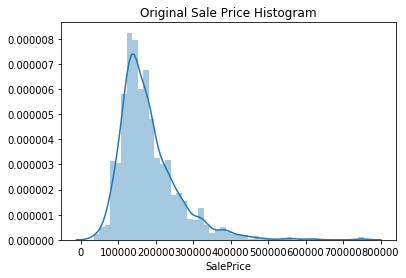

In [8]:
#타겟 데이터-시각화
plt.title('Original Sale Price Histogram')
sns.distplot(house_df['SalePrice']) #왼쪽으로 치우친 분포->로그변환 적용

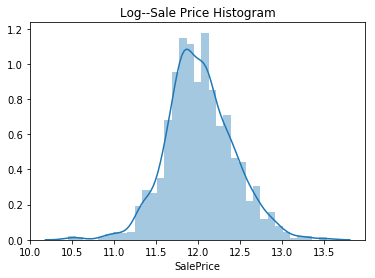

In [9]:
#로그변환 적용-> 정규분포 형태로 변화.
y_log = np.log1p(house_df['SalePrice']) #시리즈니까 바로 np.log1p를 적용가능.(tip: np 함수 적용시에는 ndarray, list, series면 다 가능)
plt.title('Log--Sale Price Histogram')
sns.distplot(y_log) 

In [10]:
##전처리 종합선물세트

#SalePrice 로그변환 : np.log1p(시리즈)
house_df['SalePrice']=np.log1p(house_df['SalePrice'])

#불필요 칼럼 삭제: df.drop()
house_df.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'Id'], axis=1, inplace=True)

#"숫자형 칼럼"만 적용가능 - 평균값으로 채우기: df.fillna(df.mean())
house_df.fillna(house_df.mean(), inplace=True)

house_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,12.247699
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,12.109016
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,12.317171
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,11.849405
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,12.429220


In [11]:
#object로 된것들엔 결측값이 남아있으므로 - null값이 있는 피처명과 데이터 타입 추출
house_df.isnull().sum()[house_df.isnull().sum()>0] #house_df.isnull().sum() :시리즈

MasVnrType       8
BsmtQual        37
BsmtCond        37
BsmtExposure    38
BsmtFinType1    37
BsmtFinType2    38
Electrical       1
GarageType      81
GarageFinish    81
GarageQual      81
GarageCond      81
dtype: int64

In [12]:
null_count = house_df.isnull().sum()[house_df.isnull().sum()>0] #null_count 또한 시리즈, 얘의 index는 피처네임
print(house_df.dtypes[null_count.index]) ###중요! house_df에서 아까 지정한 null_count의 피처에 해당하는 것들의 dtype만 추출
                                                                #결과-> 결측치들은 전부 object임. 이제 문자형 피처 제외하고는 결측치 없음.

MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


In [13]:
#X의 문자형 피처는 모두 원-핫 인코딩 변환!(결측값이 있는 문자형 피처만 그런게 아니고, 모든 문자형 피처 전부 적용!!)
house_df_oh = pd.get_dummies(house_df)

print(house_df.shape)
print(house_df_oh.shape) #원핫인코딩 적용돼서 컬럼 개수가 75->271개로 늘었다!
house_df_oh.head()

(1460, 75)
(1460, 271)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,1,0,0,0,0,1,0


- 원핫인코딩을 적용하면 결측값이 있던 피처들에 있는 문자형들이 전부 피처 하나씩으로 바뀌게 되면서 결측값이 사라짐!(원래있던 결측값 문자형 컬럼들 사라짐)

In [14]:
null_count = house_df_oh.isnull().sum()[house_df_oh.isnull().sum()>0] #null_count 또한 시리즈, 얘의 index는 피처네임
print(house_df_oh.dtypes[null_count.index]) 

Series([], dtype: object)


In [15]:
house_df_oh.isnull().sum().sum()

0

#####################결측값 처리, X, y 데이터 변환 끝!###################

### #1) "선형 회귀" 모델 -linear, ridge, lasso / 평가: RMSLE
- y를 이미 로그변환했으므로(실제값(y_test), 예측값(pred) 모두 로그로 나오므로) RMSE만 구하면 됨

In [16]:
def get_rmse(model): #로그변환된 y를 학습한 모델을 넣으면 rmse(여기선 RMSLE)를 반환
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__, '로그변환된 RMSE: ', np.round(rmse, 3))
    return rmse

#모델 여러개 넣었을 때 여러개의 rmse 반환
def get_rmses(models):
    rmses = [] #빈 리스트를 만들어놓고 
    for i in models:
        rmse = get_rmse(i)
        rmses.append(rmse) #모델을 돌릴 때마다 rmses에 rmse 를 추가
    return rmses

In [17]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [18]:
#train/test split (여기의 X는 원핫인코딩이 되어있고, y는 로그변환까지 된 데이터)
y_target = house_df_oh['SalePrice']
X_feature = house_df_oh.drop('SalePrice',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_feature, y_target, test_size=.2, random_state=156)

In [19]:
#모델
lr_reg = LinearRegression()
rid_reg = Ridge()
las_reg = Lasso()
#학습
lr_reg.fit(X_train, y_train)
rid_reg.fit(X_train, y_train)
las_reg.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [20]:
models = [lr_reg, rid_reg, las_reg]
get_rmses(models)

LinearRegression 로그변환된 RMSE:  0.132
Ridge 로그변환된 RMSE:  0.128
Lasso 로그변환된 RMSE:  0.176


[0.131895765791542, 0.12750846334053026, 0.17628250556471395]

- 릿지와 라쏘에 대해서는 후에 alpha값을 변환하는 하이퍼 파라미터 튜닝 시행
- 피처별 회귀계수 시각화해서 어떤 피처가 가장 영향력 있는지 확인!(상위 10개, 하위 10개)

In [21]:
def get_top_bottom_coef(model, n=10): #input:model, coef 상위하위 각 10개씩 반환
    coef = pd.Series(data=model.coef_, index=X_feature.columns) #coef(숫자값)와 피처명 함께 매핑!
    coef_top = coef.sort_values(ascending=False).head(n) #상위10개(양의 수로 큰것부터~10개) //당연히 뒤에 .head가 아니라 [:n]이것도 가능
    coef_bottom = coef.sort_values(ascending=False).tail(n) #하위10개(밑의 음의 수로 큰것부터~10개) //
                                                                    ##ascending=True로 해서 head10개를 뽑으면 작은 것부터~10개니까 순서가 뒤집힘.
    return coef_top, coef_bottom

In [22]:
coef_top, coef_bottom =get_top_bottom_coef(lr_reg, n=10)
type(coef_top) #coef_top, coef_bottom 으로 반환되는 것은 시리즈

pandas.core.series.Series

In [23]:
#위에서 뽑은 상하위 회귀계수들을 시각화하는 함수
def visualize_coef(models): #모델은 여러개를 넣을것(여기선 3개)
    fig, axs = plt.subplots(1,3, figsize=(24,10))
    fig.tight_layout()
    
    for i, model in enumerate(models): #인풋인 models에 대해, i: 인덱스, model:values
        coef_top, coef_bottom = get_top_bottom_coef(model, n=10) #시리즈
        coef_concat = pd.concat([coef_top, coef_bottom]) #상,하위 회귀계수를 묶은 것 #시리즈
        
        axs[i].set_title(model.__class__.__name__+'Coefficents', size=25) #제목
        axs[i].tick_params(axis="y", direction="in", pad=-120)
        
        for label in (axs[i].get_xticklabels() + axs[i].get_yticklabels()): #폰트사이즈 조정
            label.set_fontsize(22)
        
        sns.barplot(x= coef_concat.values, y= coef_concat.index, ax = axs[i])
            #주의!plt.show() 쓰면 한개plot만 출력되므로 쓰지말것.

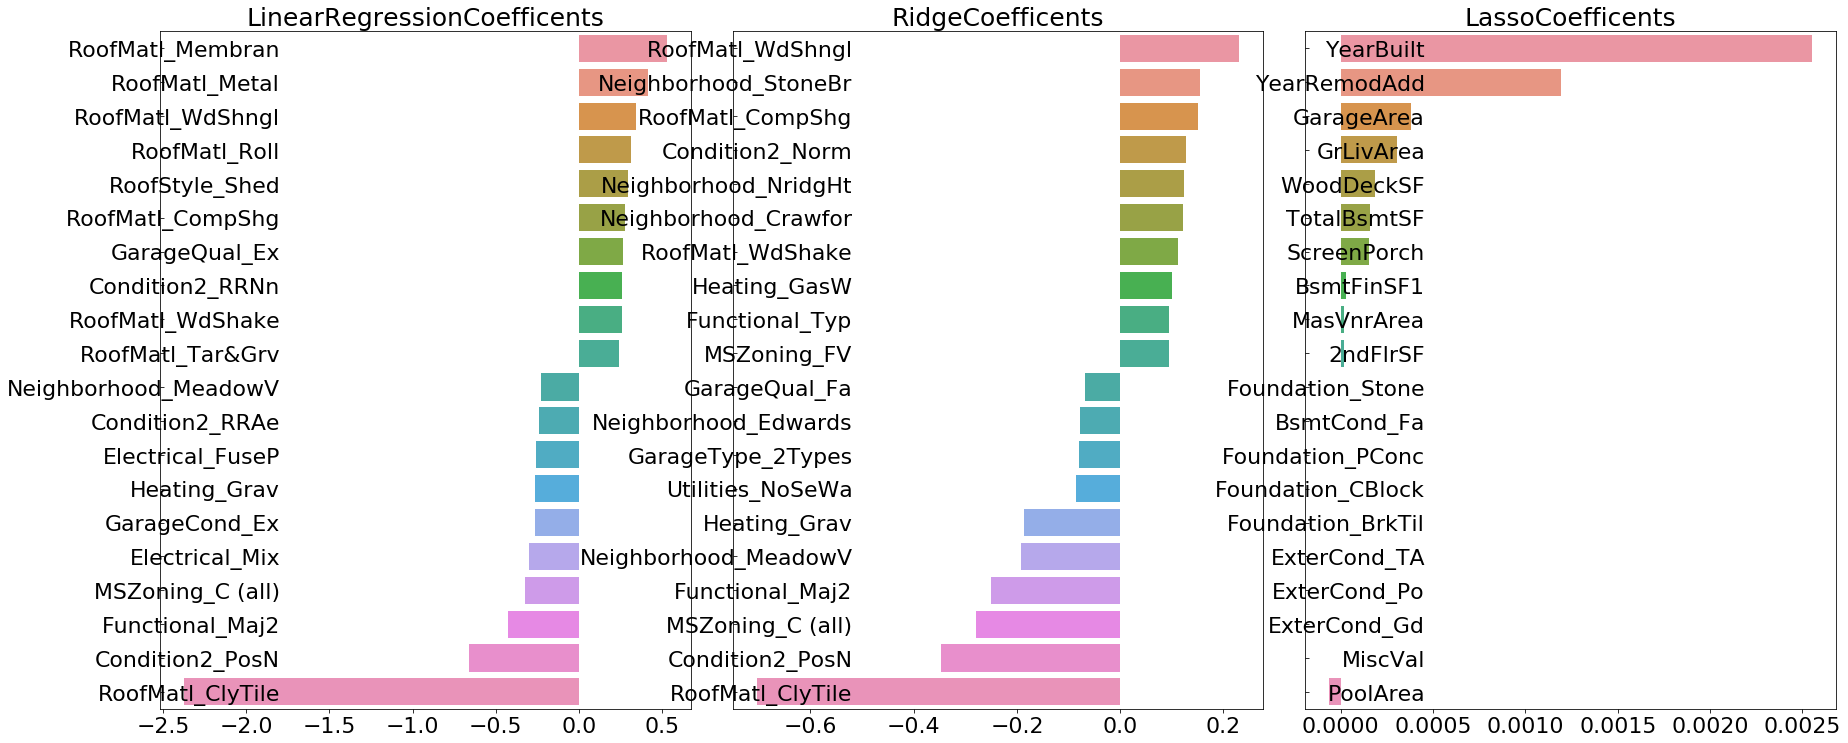

In [24]:
models = [lr_reg, rid_reg, las_reg]
visualize_coef(models)

#### <정리> RMS(L)E 출력 함수: get_rmses(models), 회귀계수 출력 함수: visualize_coef(models)
- 라쏘의 회귀계수가 다른 2개모델과 너무 다름. 
- ==>교차검증(train/test분할이 잘못됐는지? 치우쳐서 분할된건가?), 그리드서치를 이용하여 최적의 하이퍼 파라미터를 찾아보자.
### 전체 데이터를 대상으로 교차검증 & 하이퍼 파라미터 튜닝(그리드서치)

In [25]:
from sklearn.model_selection import cross_val_score, GridSearchCV

In [26]:
#교차검증 실시(train셋에 대해서만 하는게 아니라 전체 데이터 대상으로 한것임!!)
models = [lr_reg, rid_reg, las_reg]

def get_avg_rmse_cv(models): #models 리스트 투입 시
    for i in models:
        rmse_list = np.sqrt(-cross_val_score(i , X_feature, y_target, scoring='neg_mean_squared_error',cv=5)) #cv 개수만큼 나오므로
        avg_rmse = np.mean(rmse_list)
        #append하지 않고 그냥 출력만 해보자.
        print('\n {0} CV RMSE값 리스트: {1}'.format(i.__class__.__name__, np.round(rmse_list,3)))
        print('{0} 평균 RMSE값: {1}'.format(i.__class__.__name__, np.round(avg_rmse,3)))

In [27]:
get_avg_rmse_cv(models)


 LinearRegression CV RMSE값 리스트: [0.135 0.165 0.168 0.111 0.198]
LinearRegression 평균 RMSE값: 0.155

 Ridge CV RMSE값 리스트: [0.117 0.154 0.142 0.117 0.189]
Ridge 평균 RMSE값: 0.144

 Lasso CV RMSE값 리스트: [0.161 0.204 0.177 0.181 0.265]
Lasso 평균 RMSE값: 0.198


In [28]:
#릿지, 라쏘 모델을 위한 하이퍼 파라미터 튜닝하는 함수

def print_best_params(model, params):
    #객체(이미 있음)->인풋값
    #파라미터 딕셔너리->인풋값
    
    #그리드서치
    grid_model = GridSearchCV(model, params, scoring='neg_mean_squared_error', cv=5)
    #학습
    grid_model.fit(X_feature, y_target) #트레인셋만 하는게 아니라 전체데이터 대상으로 그리드서치 시행.
    #cv결과(rmse값)
    rmse = np.sqrt(-1*grid_model.best_score_) #여기서의 score는 mse니까 #best_score_는 1개만 나오므로 평균할 필요x
    print('{0} 5-cv시 최적의 스코어: {1}, 최적의 파라미터: {2}'.format(model.__class__.__name__, np.round(rmse,3), grid_model.best_params_))
    
    return grid_model.best_estimator_

In [29]:
#파라미터 설정
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }

In [30]:
print_best_params(rid_reg, ridge_params)
print_best_params(las_reg, lasso_params)

Ridge 5-cv시 최적의 스코어: 0.142, 최적의 파라미터: {'alpha': 12}
Lasso 5-cv시 최적의 스코어: 0.142, 최적의 파라미터: {'alpha': 0.001}


Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

- 최적의 하이퍼 파라미터를 적용한 모델 다시 만들기!

In [31]:
#모델
lr_reg = LinearRegression()
rid_reg = Ridge(alpha=12)
las_reg = Lasso(alpha=0.001)
#학습
lr_reg.fit(X_train, y_train)
rid_reg.fit(X_train, y_train)
las_reg.fit(X_train, y_train)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [32]:
#RMS(L)E 출력 함수
models = [lr_reg, rid_reg, las_reg]
get_rmses(models)

LinearRegression 로그변환된 RMSE:  0.132
Ridge 로그변환된 RMSE:  0.124
Lasso 로그변환된 RMSE:  0.12


[0.131895765791542, 0.12387044279987404, 0.11995999974065168]

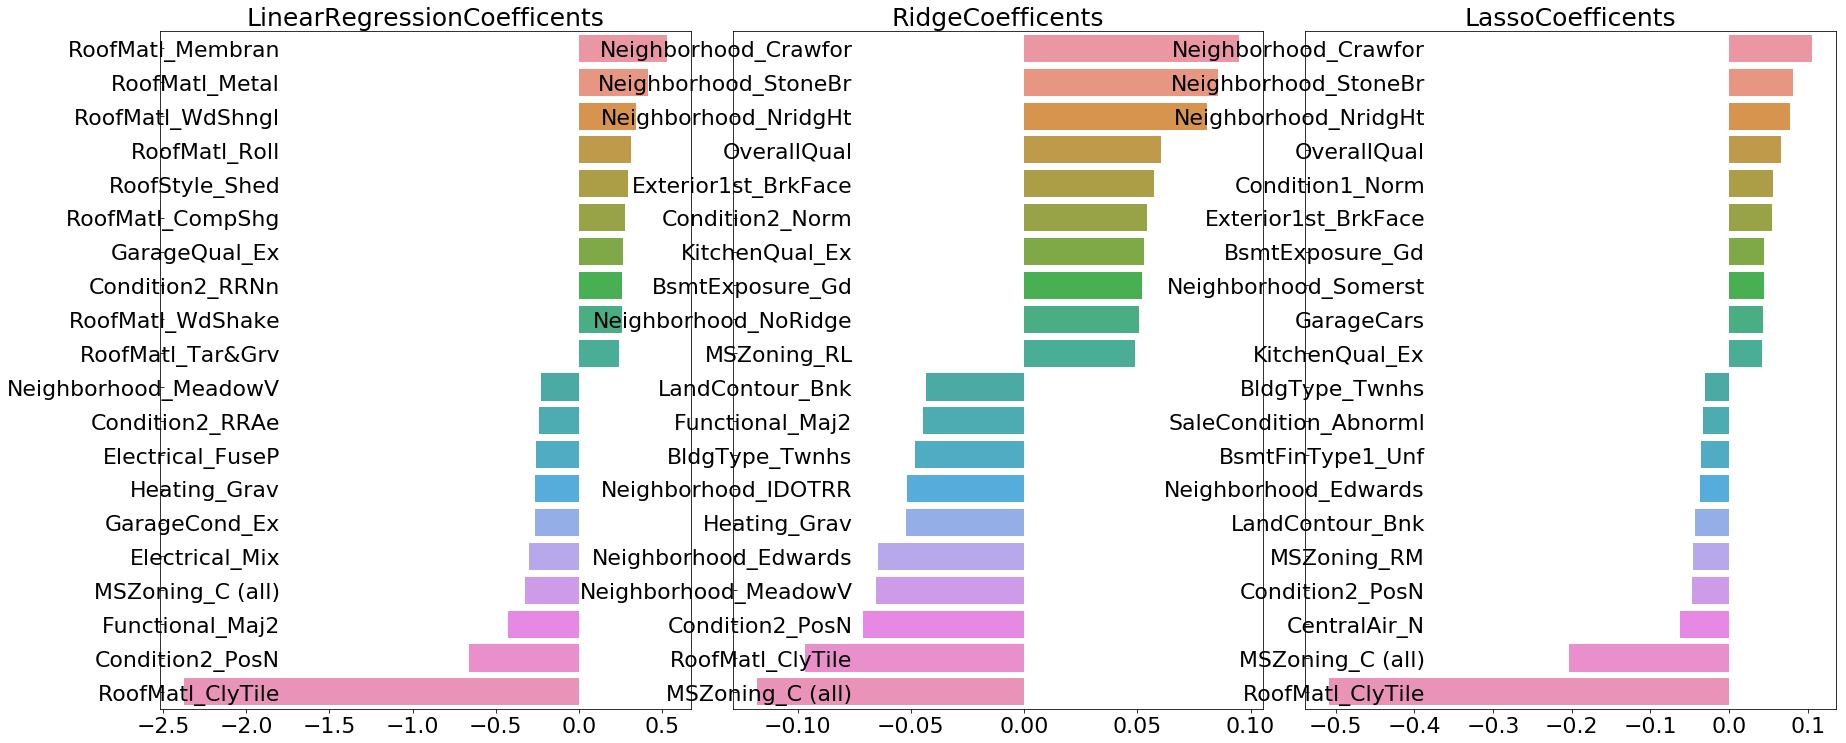

In [33]:
#회귀계수 시각화 함수
models = [lr_reg, rid_reg, las_reg]
visualize_coef(models)

#### 모델 튜닝 - 1.피처 데이터(X)의 데이터 분포도 확인 
- 피처데이터의 숫자형 칼럼의 왜곡 정도 파악->skew() 함수 사용 : skew(왜곡)가 1보다 큰 것에 대해 로그변환
- 여기서 원핫인코딩된 칼럼은 제외해야 하므로, house_df를 사용(house_df_oh 사용X)

In [34]:
from scipy.stats import skew

In [35]:
#숫자형 피처(칼럼)만 추출(index로 추출)
ftr_index = house_df.dtypes[house_df.dtypes!='object'].index
ftr_index #숫자형 피처들

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [36]:
house_df.dtypes[house_df.dtypes!='object'] #전부 숫자형 피처

MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice        float64
dtype: object

In [37]:
#뽑은 숫자형 피처들에서
skew_ftr = house_df[ftr_index].apply(lambda x: skew(x))
skew_ftr #왜곡 정도를 확인. 이 값이 1보다 크면 왜곡된것임. #시리즈

MSSubClass        1.406210
LotFrontage       2.382499
LotArea          12.195142
OverallQual       0.216721
OverallCond       0.692355
YearBuilt        -0.612831
YearRemodAdd     -0.503044
MasVnrArea        2.673661
BsmtFinSF1        1.683771
BsmtFinSF2        4.250888
BsmtUnfSF         0.919323
TotalBsmtSF       1.522688
1stFlrSF          1.375342
2ndFlrSF          0.812194
LowQualFinSF      9.002080
GrLivArea         1.365156
BsmtFullBath      0.595454
BsmtHalfBath      4.099186
FullBath          0.036524
HalfBath          0.675203
BedroomAbvGr      0.211572
KitchenAbvGr      4.483784
TotRmsAbvGrd      0.675646
Fireplaces        0.648898
GarageYrBlt      -0.667488
GarageCars       -0.342197
GarageArea        0.179796
WoodDeckSF        1.539792
OpenPorchSF       2.361912
EnclosedPorch     3.086696
3SsnPorch        10.293752
ScreenPorch       4.117977
PoolArea         14.813135
MiscVal          24.451640
MoSold            0.211835
YrSold            0.096170
SalePrice         0.121222
d

In [38]:
skew_ftr_top = skew_ftr[skew_ftr>1] #시리즈에 불린인덱싱 적용.->skew가 1보다 큰것만 뽑음
skew_ftr_top.sort_values(ascending=False) #내림차순 정렬

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64

In [39]:
skew_ftr_top.index #왜곡이 심한 피처들->얘네한테만 로그변환

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtHalfBath', 'KitchenAbvGr', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

- df[col] =np.log1p(df[col]) :로그변환

In [40]:
house_df[skew_ftr_top.index] = np.log1p(house_df[skew_ftr_top.index]) #로그변환 한꺼번에! #house_df[skew_ftr_top.index]은 df 
house_df.head() #왜곡정도가 높은 숫자형 피처들이 로그변환됨.

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,4.110874,RL,4.189655,9.042040,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0.000000,0.0,0.0,0.0,0.0,2,2008,WD,Normal,12.247699
1,3.044522,RL,4.394449,9.169623,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0.000000,0.0,0.0,0.0,0.0,5,2007,WD,Normal,12.109016
2,4.110874,RL,4.234107,9.328212,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0.000000,0.0,0.0,0.0,0.0,9,2008,WD,Normal,12.317171
3,4.262680,RL,4.110874,9.164401,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,5.609472,0.0,0.0,0.0,0.0,2,2006,WD,Abnorml,11.849405
4,4.110874,RL,4.442651,9.565284,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0.000000,0.0,0.0,0.0,0.0,12,2008,WD,Normal,12.429220


In [41]:
#다시 skew정도를 확인해보면
skew_ftr = house_df[ftr_index].apply(lambda x: skew(x))
skew_ftr_top = skew_ftr[skew_ftr>1]
skew_ftr_top.sort_values(ascending=False) #이전보다 많이 줄음

PoolArea         14.348342
3SsnPorch         7.727026
LowQualFinSF      7.452650
MiscVal           5.165390
BsmtHalfBath      3.929022
KitchenAbvGr      3.865437
ScreenPorch       3.147171
BsmtFinSF2        2.521100
EnclosedPorch     2.110104
dtype: float64

In [42]:
#그럼 다시 원핫인코딩 적용, 데이터 지정
house_df_oh = pd.get_dummies(house_df)
#train/test split (여기의 X는 원핫인코딩+로그변환이 되어있고, y는 로그변환까지 된 데이터)
y_target = house_df_oh['SalePrice']
X_feature = house_df_oh.drop('SalePrice',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_feature, y_target, test_size=.2, random_state=156)

In [43]:
##다시 만든 데이터로 하이퍼 파라미터 튜닝!(이건 X, y 전체데이터 사용)

#파라미터 설정
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }

print_best_params(rid_reg, ridge_params) ##릿지의 경우에는 파라미터 값이 바뀜. 그리고 두 모델 다 스코어 값이 향상됨(줄어듦)
print_best_params(las_reg, lasso_params)

Ridge 5-cv시 최적의 스코어: 0.128, 최적의 파라미터: {'alpha': 10}
Lasso 5-cv시 최적의 스코어: 0.125, 최적의 파라미터: {'alpha': 0.001}


Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

LinearRegression 로그변환된 RMSE:  0.128
Ridge 로그변환된 RMSE:  0.122
Lasso 로그변환된 RMSE:  0.119


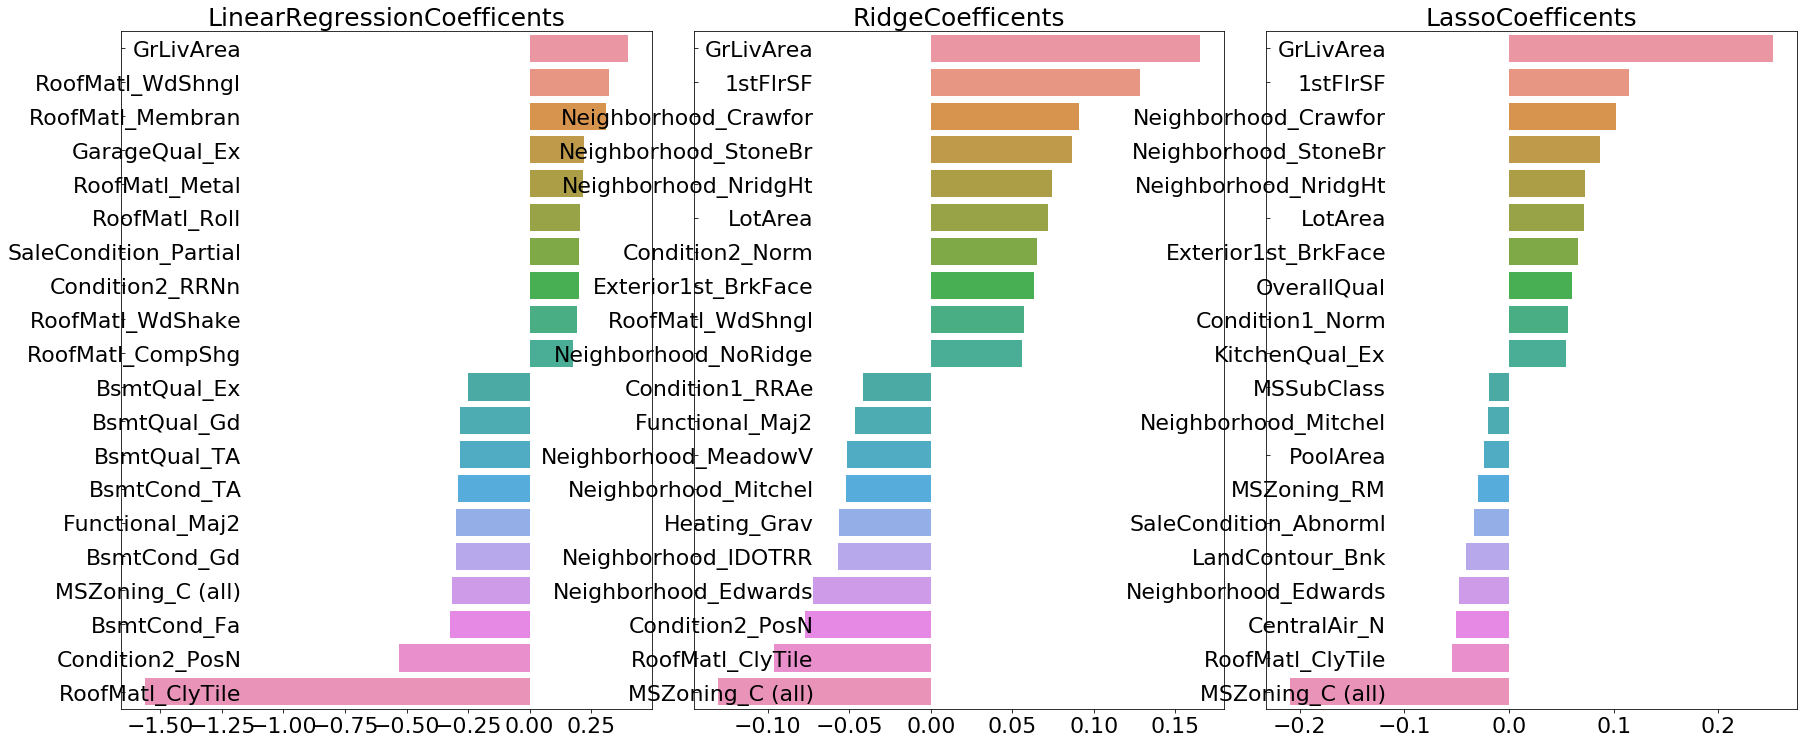

In [44]:
#변화된 데이터와, 하이퍼 파라미터 튜닝을 적용한 모델 학습-예측-평가

#모델
lr_reg = LinearRegression()
rid_reg = Ridge(alpha=10)
las_reg = Lasso(alpha=0.001)
#학습
lr_reg.fit(X_train, y_train)
rid_reg.fit(X_train, y_train)
las_reg.fit(X_train, y_train)

#RMS(L)E 출력 함수
models = [lr_reg, rid_reg, las_reg]
get_rmses(models)

#회귀계수 시각화 함수
models = [lr_reg, rid_reg, las_reg]
visualize_coef(models)

#### 모델 튜닝 -  2. 이상치 데이터 처리
- 어떠한 칼럼에도 이상치 데이터가 있을 수 있지만, 그중에서도 가장 중요한 것은 "예측에 많은 영향을 끼치는 칼럼"에 대해서 이상치데이터를 처리해야 함.
- 예측에 많은 영향을 끼치는 피처 -> 회귀계수가 크다, 상관계수가 크다

Text(0, 0.5, 'SalePrice')

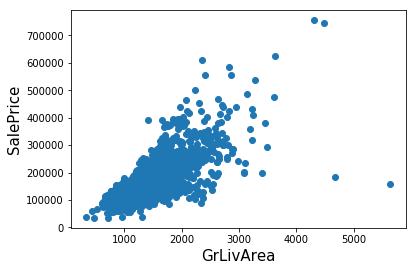

In [45]:
#세 모델에서 가장 회귀계수가 컸던 GrLivArea와 타겟(SalePrice) -->scatter로 표현해보면 아웃라이어가 2개 있음.
#데이터는 원본인 house_df_org 사용

plt.scatter(house_df_org['GrLivArea'], house_df_org['SalePrice'])
plt.xlabel('GrLivArea', fontsize=15) #label 안에 fontsize도 설정가능!
plt.ylabel('SalePrice', fontsize=15)

In [46]:
house_df_org[['GrLivArea','SalePrice']].corr() #상관관계도 높은편

,GrLivArea,SalePrice
GrLivArea,1.000000,0.708624
SalePrice,0.708624,1.000000


In [47]:
#'GrLivArea'의 이상치데이터 삭제: 4000이상인데도 saleprice가 500,000 이하인 데이터 삭제 -> 사용할 데이터인 house_df_oh에서 삭제
 ##모두 로그변환된 상태, df의 단위를 변경할필욘 없고 np.log1p(4000) 이렇게 바꾸면 되겠지?

drop_ind = house_df_oh[(house_df_oh['GrLivArea']>np.log1p(4000)) & (house_df_oh['SalePrice']<np.log1p(500000))].index #우리가 삭제할 2개의 아웃라이어의 인덱스
house_df_oh.drop(drop_ind, axis=0, inplace=True)
house_df_oh.shape #2개삭제됨(1460->1458)

(1458, 271)

In [48]:
#아웃라이어를 삭제했으니 다시 수행해보자..!(이게 몇번째야)

#train/test split (여기의 X는 원핫인코딩+로그변환+아웃라이어삭제이 되어있고, y는 로그변환+아웃라이어삭제까지 된 데이터)
y_target = house_df_oh['SalePrice']
X_feature = house_df_oh.drop('SalePrice',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_feature, y_target, test_size=.2, random_state=156)

In [49]:
##다시 만든 데이터로 하이퍼 파라미터 튜닝!(이건 X, y 전체데이터 사용)

#파라미터 설정
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }

print_best_params(rid_reg, ridge_params) ##릿지의 경우에는 파라미터 값(10->8)이 바뀜. 그리고 두 모델 다 스코어 값이 향상됨(줄어듦)
print_best_params(las_reg, lasso_params)

Ridge 5-cv시 최적의 스코어: 0.113, 최적의 파라미터: {'alpha': 8}
Lasso 5-cv시 최적의 스코어: 0.112, 최적의 파라미터: {'alpha': 0.001}


Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

LinearRegression 로그변환된 RMSE:  0.129
Ridge 로그변환된 RMSE:  0.103
Lasso 로그변환된 RMSE:  0.1


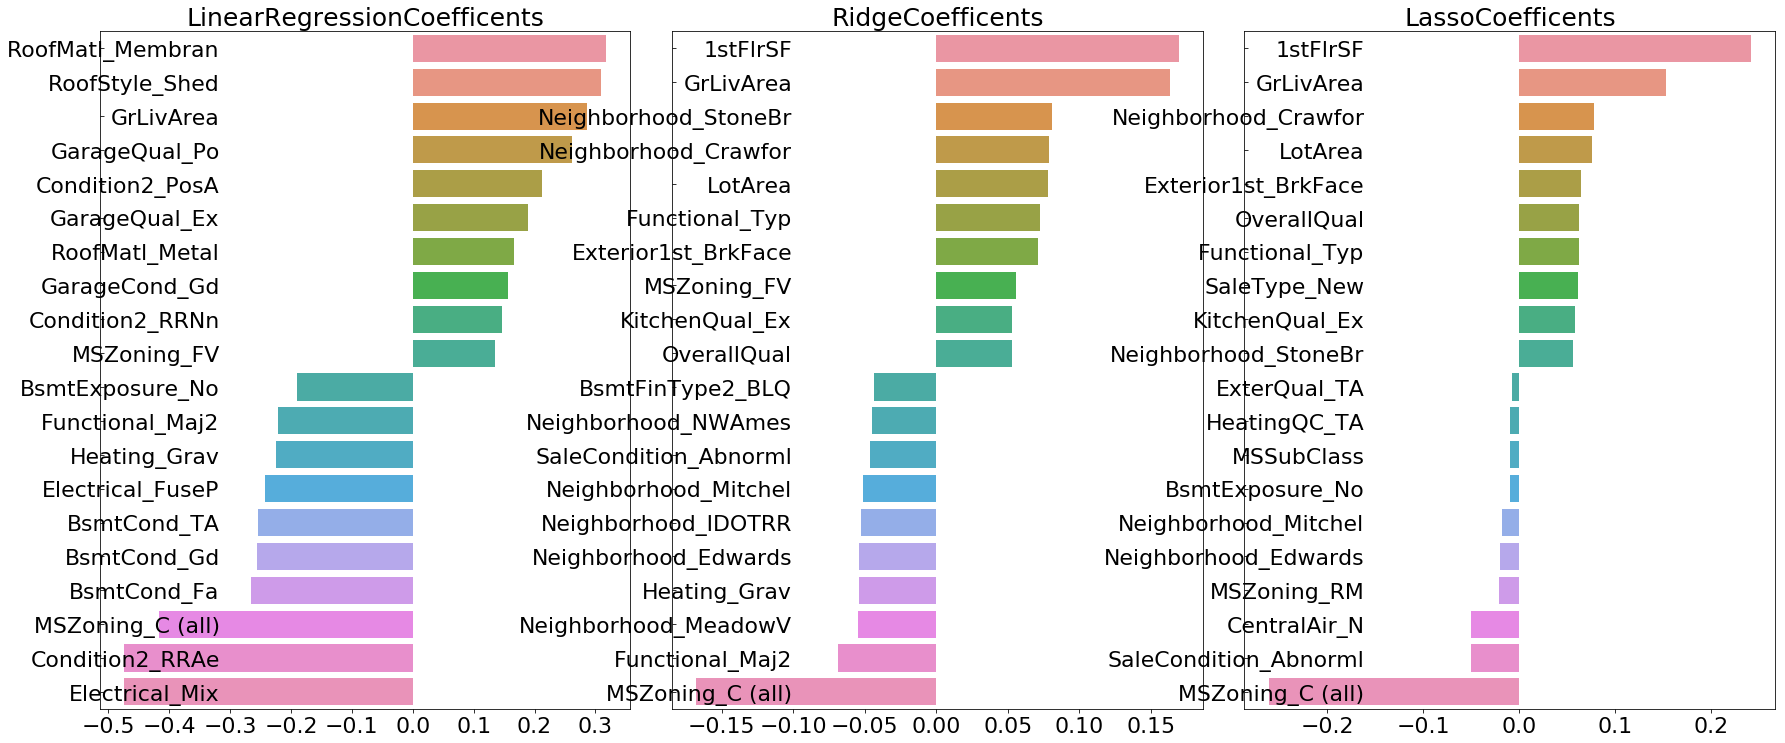

In [50]:
#변화된 데이터와, 하이퍼 파라미터 튜닝을 적용한 모델 학습-예측-평가

#모델
lr_reg = LinearRegression()
rid_reg = Ridge(alpha=8)
las_reg = Lasso(alpha=0.001)
#학습
lr_reg.fit(X_train, y_train)
rid_reg.fit(X_train, y_train)
las_reg.fit(X_train, y_train)

#RMS(L)E 출력 함수
models = [lr_reg, rid_reg, las_reg]
get_rmses(models)

#회귀계수 시각화 함수
models = [lr_reg, rid_reg, las_reg]
visualize_coef(models)

### #2) "회귀 트리" 모델 -xgb, lgbm / 평가: RMSLE
- y를 이미 로그변환했으므로(실제값(y_test), 예측값(pred) 모두 로그로 나오므로) RMSE만 구하면 됨

In [51]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [52]:
#xgb-하이퍼 파라미터 튜닝
xgb_params = {'n_estimator':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
print_best_params(xgb_reg, xgb_params)

[15:44:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:44:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:45:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor 5-cv시 최적의 스코어: 0.115, 최적의 파라미터: {'n_estimator': 1000}


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.5, gamma=0,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimator=1000,
       n_estimators=1000, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=0.8, verbosity=1)

In [53]:
#lgbm-하이퍼 파라미터 튜닝
lgbm_params = {'n_estimator':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
print_best_params(lgbm_reg, lgbm_params)

LGBMRegressor 5-cv시 최적의 스코어: 0.116, 최적의 파라미터: {'n_estimator': 1000}


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.4,
       importance_type='split', learning_rate=0.05, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimator=1000, n_estimators=1000, n_jobs=-1, num_leaves=4,
       objective=None, random_state=None, reg_alpha=0.0, reg_lambda=10,
       silent=True, subsample=0.6, subsample_for_bin=200000,
       subsample_freq=0)

In [54]:
#최적의 하이퍼 파라미터를 학습한 best estimator를 추출!->이것을 시각화 시 대입할 것임.
best_xgb = print_best_params(xgb_reg, xgb_params)
best_lgbm = print_best_params(lgbm_reg, lgbm_params)

[15:45:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:45:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:45:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:45:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:45:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:45:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor 5-cv시 최적의 스코어: 0.115, 최적의 파라미터: {'n_estimator': 1000}
LGBMRegressor 5-cv시 최적의 스코어: 0.116, 최적의 파라미터: {'n_estimator': 1000}


- 모델의 중요도 상위 20개의 피처명과 그때의 중요도값을 Series로 반환. ###xgb, lgbm 시각화에서도 feature_importances_ 쓴다!

In [55]:
# 모델의 중요도 상위 20개의 피처명과 그때의 중요도값을 Series로 반환. ###xgb, lgbm 시각화에서도 feature_importances_ 쓴다!
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X_feature.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    fig, ax = plt.subplots(1,2, figsize=(24,10))
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화. 
    for i_num, model in enumerate(models):
        ftr_top20 = get_top_features(model)
        ax[i_num].set_title(model.__class__.__name__+' Feature Importances', size=25)
        
        for label in (ax[i_num].get_xticklabels() + ax[i_num].get_yticklabels()): #font 크기 조정.
            label.set_fontsize(22) 
            sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=ax[i_num]) #for loop 안에 넣어야함

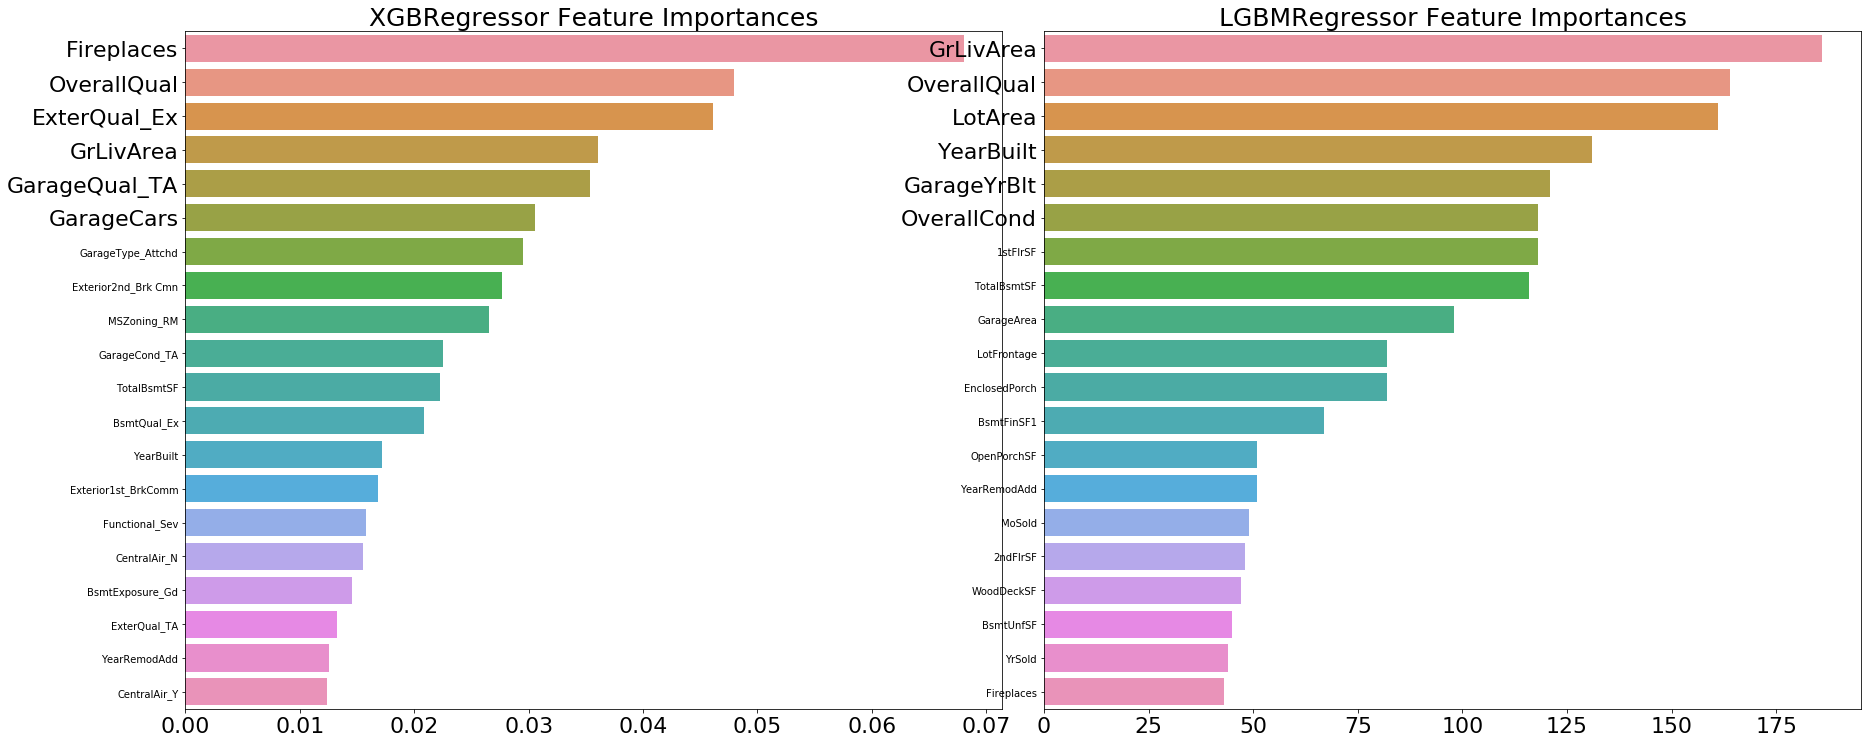

In [56]:
models = [best_xgb, best_lgbm]
visualize_ftr_importances(models)

### #3) "회귀 모델 혼합" 모델 -다양한 모델 혼합 / 평가: RMSLE
- y를 이미 로그변환했으므로(실제값(y_test), 예측값(pred) 모두 로그로 나오므로) RMSE만 구하면 됨
- 모델1: 릿지+라쏘
- 모델2: xgb+lgbm

In [57]:
#개별모델, 최종혼합모델의 RMSE 값 출력 함수

#가중치 줄 preds는 preds = {'최종 혼합':pred, 'ridge':rid_pred, 'lasso':las_pred} 이렇게 생겼다!

def get_rmse_pred(preds): #(얼마의 가중치를 줄지의)딕셔너리를 주면 rmse를 출력함.(print로만)
    for key in preds.keys(): #'최종혼합', 'ridge', 'lasso'들어가게 됨
        pred_value = preds[key] #예측값들(pred)에 대해 rmse 반환
        mse = mean_squared_error(y_test, pred_value)
        rmse = np.sqrt(mse)
        print('{0} 모델의 RMSE: {1:.3f}'.format(key, rmse)) #여기선 3번 출력될 것.

In [58]:
######첫번째
#모델
rid_reg = Ridge(alpha=8)
las_reg = Lasso(alpha=0.001)
#학습
rid_reg.fit(X_train, y_train)
las_reg.fit(X_train, y_train)

#예측-타입이 ndarray
rid_pred = rid_reg.predict(X_test)
las_pred = las_reg.predict(X_test)

pred = 0.4*rid_pred + 0.6*las_pred #이렇게 가중치를 준것은 릿지(0.103)보다 라쏘(0.1)가 더 성능이 좋아서 더준것.
preds = {'최종 혼합':pred, 'ridge':rid_pred, 'lasso':las_pred}

print(type(rid_pred))

<class 'numpy.ndarray'>


In [59]:
get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.100
ridge 모델의 RMSE: 0.103
lasso 모델의 RMSE: 0.100


In [60]:
########2번째
#모델
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
#학습
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)

#예측
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred= lgbm_reg.predict(X_test)
pred = 0.5*xgb_pred + 0.5*lgbm_pred #이번엔 가중치를 둘다 동일하게 줌
preds = {'최종 혼합':pred, 'xgb':xgb_pred, 'lgbm':lgbm_pred}


[15:46:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [61]:
get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.099
xgb 모델의 RMSE: 0.101
lgbm 모델의 RMSE: 0.102


### #4) "스태킹 앙상블" 모델  / 평가: RMSLE
- y를 이미 로그변환했으므로(실제값(y_test), 예측값(pred) 모두 로그로 나오므로) RMSE만 구하면 됨
- 코드는 이전에 분류에서 만든것을 그대로 쓰되, 들어가는 "모델"과 "평가지표"만 바꾸면 된다!

- step 1. 개별 모델에 하나씩 적용후, 최종 학습데이터와 최종 테스트데이터를 만들기 위해 stack하기

In [62]:
from sklearn.model_selection import KFold

In [63]:
#이 함수는 모델 1개당 1번씩 적용하는 함수, 여기서 나온 학습 및 테스트데이터는 모델 각각에서 나온 것을 모두 stack하여 "최종" 을 만들게 됨.

def get_stacking_base_datasets(model, X_train, y_train, X_test, n_folds):
    #지정된 k값만큼 kfold 생성
    kf = KFold(n_splits=n_folds, shuffle=False, random_state=0)
    #최종학습데이터/최종테스트데이터 초기화
    train_fold_pred = np.zeros((X_train.shape[0],1)) #최종 학습 데이터 개수는 사실 X_train.shape[0] 개수랑 똑같이 나옴
    test_pred = np.zeros((X_test.shape[0],n_folds)) #최종 테스트 데이터 개수는 n_fold 한 만큼 나오고, 나중에 이를 평균해야 함.
    print(model.__class__.__name__, '  MODEL 시작 ')
    
    #train셋 대상으로 cv // test셋 대상으로 예측
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train)):
        print('\t 폴드 세트: ', folder_counter, ' 시작 ')
        X_tr = X_train[train_index]
        y_tr = y_train[train_index]
        X_te = X_train[valid_index]
        
        model.fit(X_tr, y_tr) #학습
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1) #검증셋으로 예측하고 이것을 최종 학습 데이터 내에 저장.--cv개수만큼 stack.
        test_pred[:, folder_counter] = model.predict(X_test) #X_test로 예측하고 이것을 최종 테스트 데이터 내에 저장.(앞에서 cv한 개수만큼)->나중에 평균
        
    #최종 테스트 데이터에 있는(cv 개수만큼 컬럼 있음) 것들 평균해서 컬럼 하나로 만들기
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    
    return train_fold_pred, test_pred_mean #최종 나오는 것은 '최종학습데이터'와 '최종테스트데이터'

In [64]:
# get_stacking_base_datasets( )은 넘파이 ndarray를 인자로 사용(그떄는 sklearn데이터 썼음). 여기서는 캐글 df를 사용했으므로 df-> array로! 
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 개별 기반(Base)모델이 생성한 학습용/테스트용 데이터 반환. (cv=5로 통일)
ridge_train, ridge_test = get_stacking_base_datasets(rid_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(las_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)  
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge   MODEL 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso   MODEL 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
XGBRegressor   MODEL 시작 
	 폴드 세트:  0  시작 
[15:46:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  1  시작 
[15:46:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  2  시작 
[15:46:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  3  시작 
[15:46:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  4  시작 
[15:46:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
LGBMRegressor   MODEL 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  

In [65]:
#앞의 각 모델별로 최종학습데이터, 최종테스트데이터가 나왔는데 그것들 각각 stack해야됨.
Stack_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
Stack_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1)

#잘됐는지 확인
print('원본 train셋: ', X_train_n.shape, y_train_n.shape)
print('원본 test셋: ', X_test_n.shape)

원본 train셋:  (1166, 270) (1166,)
원본 test셋:  (292, 270)


In [66]:
print('stack후 train셋: ', Stack_X_train.shape)
print('stack후 test셋: ', Stack_X_test.shape)

stack후 train셋:  (1166, 4)
stack후 test셋:  (292, 4)


- step2. 최종 메타 모델을 만들고 학습,예측시키기

In [67]:
#이제 메타 모델에게 학습, 예측, 평가를 시켜보자.

#메타모델은 라쏘를 사용
las_final = Lasso(alpha=0.0005)
#학습- stack_X_train과 y_train 넣고
las_final.fit(Stack_X_train, y_train)
#예측-stack_X_test 넣고
stack_final = las_final.predict(Stack_X_test)
#평가- 위의 예측값과 정답값(y_test)와 비교
mse = mean_squared_error(stack_final, y_test)
rmse = np.sqrt(mse)
print('최종 메타 모델의 RMSLE: {0:.4f}'.format(rmse))

최종 메타 모델의 RMSLE: 0.0974


#원래 개별모델들의 rmsle값은 0.1..정도 였는데 여기서 만든 스태킹은 0.09로 가장 향상되었음!